In [1]:
import darknet.python.darknet as dn
import glob
import sys
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from src.label import Label, lwrite, Shape, dknet_label_conversion
from src.utils import crop_region, image_files_from_folder, im2single, nms
from src.keras_utils import load_model, detect_lp
from src.drawing_utils import draw_label, draw_losangle, write2img
import math
import cv2
import tempfile
from os.path import splitext, basename, isdir, join

In [26]:
class CarLicensePlatePredictor:
    
    def __init__(self, path_to_models, ):
        self.vehicle_threshold = .5

        self.vehicle_weights = join(path_to_models, 'vehicle-detector/yolo-voc.weights')
        self.vehicle_netcfg  = join(path_to_models, 'vehicle-detector/yolo-voc.cfg')
        self.vehicle_dataset = join(path_to_models, 'vehicle-detector/voc.data')

        self.vehicle_net  = dn.load_net(self.vehicle_netcfg, self.vehicle_weights, 0)
        self.vehicle_meta = dn.load_meta(self.vehicle_dataset)
        
        self.lp_threshold = .5

        self.wpod_net_path = "data/lp-detector/wpod-net_update1.json"
        self.wpod_net = load_model(self.wpod_net_path)
        
        self.ocr_threshold = .4

        self.ocr_weights = 'data/ocr/ocr-net.weights'
        self.ocr_netcfg  = 'data/ocr/ocr-net.cfg'

        self.ocr_dataset = 'data/ocr/ocr-net.data'

        self.ocr_net  = dn.load_net(self.ocr_netcfg, self.ocr_weights, 0)
        self.ocr_meta = dn.load_meta(self.ocr_dataset)
        
        self.logo_path = 'logo_leboncoin.png'
        self.logo = Image.open(self.logo_path)
        
    def process_from_path(self, image_path):
        image = Image.open(image_path)
        car_image, car_label = self.detect_cars(image_origin=np.array(image, dtype=np.uint8), image_path=image_path)
        license_plate_image, license_plate_shape = self.detect_license_plate(car_image)
        license_plate_value = self.extract_text_from_image(license_plate_image)
        x1, y1, diff, icon_to_paste = self.process_icon_on_license_plate(image, car_label, license_plate_shape)
        image_with_icon = self.add_icon_to_image(image, icon_to_paste, x1, y1, diff)
        return image_with_icon, license_plate_value
    
    def extract_license_plate(self,image_path):
        image = Image.open(image_path)
        car_image, car_label = self.detect_cars(image_origin=np.array(image, dtype=np.uint8), image_path=image_path)
        license_plate_image, license_plate_shape = self.detect_license_plate(car_image)
        license_plate_value = self.extract_text_from_image(license_plate_image)
        return license_plate_image, license_plate_value
    
    
    def add_icon_to_image(self, image, icon, license_plate_left_corner_x, license_plate_left_corner_y, diff):
        image.paste(icon, (license_plate_left_corner_x, license_plate_left_corner_y-diff), icon)
        return image

    def detect_cars(self, image_origin, image_path):
        R,_ = dn.detect(self.vehicle_net, self.vehicle_meta, image_path ,thresh=self.vehicle_threshold)

        WH = np.array(image_origin.shape[1::-1],dtype=float)
        car_list = []
        widths = []
        heights = []
        car_images = []
        car_labels = []
        
        for i,r in enumerate(R):
            cx,cy,w,h = (np.array(r[2])/np.concatenate( (WH,WH) )).tolist()
            widths.append(w), heights.append(h)
            tl = np.array([cx - w/2., cy - h/2.])
            br = np.array([cx + w/2., cy + h/2.])
            label = Label(0,tl,br)
            car_image = crop_region(image_origin, label).astype("uint8")
            car_images.append(car_image)
            car_labels.append(label)
            
        best_car_image = car_images[np.argmax(widths)]
        return car_images[np.argmax(widths)], car_labels[np.argmax(widths)]
    
    def detect_license_plate(self,  image):
        ratio = float(max(image.shape[:2]))/min(image.shape[:2])
        side  = int(ratio*288.)
        bound_dim = min(side + (side%(2**4)),608)
        
        license_plate_list, license_plate_image_list, _ = detect_lp(self.wpod_net, 
                                                                    im2single(image),
                                                                    bound_dim,
                                                                    2**4,
                                                                    (240,80),
                                                                    self.lp_threshold)
        
        if len(license_plate_image_list):
            license_plate_image = license_plate_image_list[0]
            license_plate_image = cv2.cvtColor(license_plate_image, cv2.COLOR_BGR2GRAY)
            license_plate_image = cv2.cvtColor(license_plate_image, cv2.COLOR_GRAY2BGR)
            
            license_plate_shape = Shape(license_plate_list[0].pts)

        else:
            raise Exception("No license plate found")
            
        return license_plate_image, license_plate_shape
            
    def extract_text_from_image(self,  license_plate_image):
        with tempfile.NamedTemporaryFile(suffix=".png") as temporary_file_name:
            fname = temporary_file_name.name
            cv2.imwrite(str(fname), license_plate_image*255.)
            R,(width,height) = dn.detect(self.ocr_net, self.ocr_meta, fname ,thresh=self.ocr_threshold, nms=None)
            if len(R):
                L = dknet_label_conversion(R,width,height)
                L = nms(L,.45)

                L.sort(key=lambda x: x.tl()[0])
                lp_str = ''.join([chr(l.cl()) for l in L])
            else:
                raise Exception("Failed to extract text")
        return lp_str
    
    def process_icon_on_license_plate(self, image, car_label, license_plate_shape):
        pts = license_plate_shape.pts*car_label.wh().reshape(2,1) + car_label.tl().reshape(2,1)
        ptspx = pts*np.array(np.asarray(image).shape[1::-1],dtype=float).reshape(2,1)
        
        x1 = int(ptspx[0][0])
        y1 = int(ptspx[1][0])
        x2 = int(ptspx[0][1])
        y2 = int(ptspx[1][1])
        x3 = int(ptspx[0][2])
        y3 = int(ptspx[1][2])
        x4 = int(ptspx[0][3])
        y4 = int(ptspx[1][3])
        
        height = int(((x1-x2)**2+(y1-y2)**2)**.5)
        width = int(((x4-x1)**2 + (y4-y1)**2)**.5)

        angle_to_rotate = -math.degrees(math.atan2(y2-y1, x2-x1))
        diff = 0 if angle_to_rotate < 0 else int((height**2-(x2-x1)**2)**.5)
        
        icon = self.logo.convert('RGBA').resize((height, width))
        resized_and_rotate_icon = icon.rotate(angle_to_rotate, expand=1)
        return x1, y1, diff, resized_and_rotate_icon
        
        

In [3]:
cpp = CarLicensePlatePredictor(path_to_models="./data/")

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [21]:
PATH = "./sample_lbc/a77d6638f852876c65ecf367c9629a9f31f33a22.jpg"

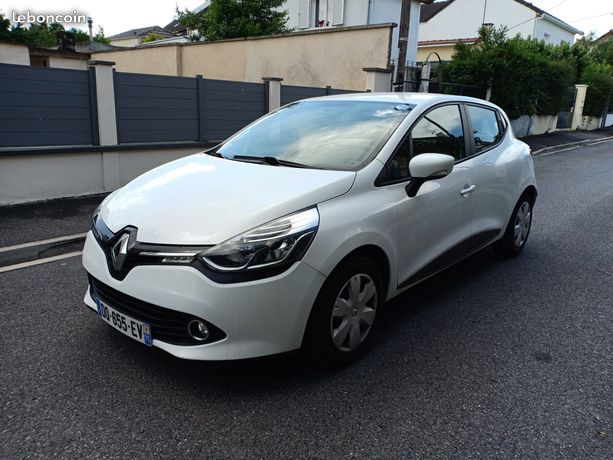

In [22]:
Image.open(PATH)

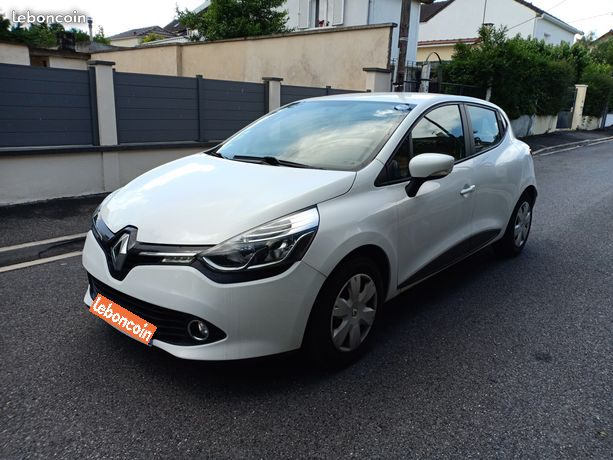

In [23]:
image, value = cpp.process_from_path(PATH)
image

In [24]:
value

'0665EV'